## Prelimiar activities

In [ ]:
import os
import pandas as pd
import numpy as np
#import ijson   #uncomment before deliver
import time
from tqdm.notebook import tqdm
import csv
import json
import random
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import heapq
from sortedcontainers import SortedList
import itertools
import networkx as nx
import matplotlib.pyplot as plt
import ast
from collections import defaultdict
import ast
from itertools import combinations


# **[Q1] Data**

In [ ]:
file_path = 'dblp.v12.json'

### Loading the dataset

The main problem with the loading and saving actions on this dataset was related to its dimension, around 12 GB, that made it impossible to read through usual reading techniques, such as 'pd.read_json()'. The strategy that we used to manage the problem was processing the original JSON file in batches and splitting it into 2 parts based on the total number of papers; the results were stored into 2 Dataframes, 'data_part1' and 'data_part2'. These 2 datasets were saved in the 'csv' format to make them easier to open, once stored in the computer. Finally, they were merged to form a new dataset, 'citations_dataset_final.csv', that we will use for the whole Point 1.

In [ ]:
# we decide the size of the batches and on the max number of paper that the data_part1 should contain
BATCH_SIZE = 10000
TOTAL_PAPERS = 3000000

# we define the columns for the final dataset
columns = ['id', 'num_authors', 'authors', 'n_citation', 'reference_count', 'references']

# we inizialize the 2 Dataframes, data_part1 and data_part2, that will compose the final dataset
data_part1 = pd.DataFrame(columns=columns)
data_part2 = pd.DataFrame(columns=columns)

# open the file using ijson to be able to iterate through the JSON objects
with open(file_path, "rb") as f:
    batch = []

    # the track of the iteration is kept by using tqdm
    for i, element in tqdm(enumerate(ijson.items(f, "item")),
                           desc="Processing Papers", unit=" papers", total=TOTAL_PAPERS):
        paper = {}
        paper['id'] = element['id']

        # information are extracted about the authors
        authors = element.get('authors')
        if authors:
            paper['num_authors'] = len(authors)
            paper['authors'] = [auth for auth in authors]

        # information are extracted about the citation count
        n_citation = element.get('n_citation')
        paper['n_citation'] = n_citation if n_citation else 0

        # infomration are extracted about the references
        references = element.get('references')
        paper['reference_count'] = len(references) if references else np.nan
        paper['references'] = references if references else np.nan

        batch.append(paper)

        # check if the batch is ready to be processed
        if len(batch) == BATCH_SIZE:
            if i < TOTAL_PAPERS / 2:
                data_part1 = pd.concat([data_part1, pd.DataFrame(batch)],
                                       ignore_index=True)
            else:
                data_part2 = pd.concat([data_part2, pd.DataFrame(batch)],
                                       ignore_index=True)

            batch = []

    # process the remaining papers in the last batch
    if i < TOTAL_PAPERS / 2:
        data_part1 = pd.concat([data_part1, pd.DataFrame(batch)],
                               ignore_index=True)
    else:
        data_part2 = pd.concat([data_part2, pd.DataFrame(batch)],
                               ignore_index=True)

# store the 2 resulting datasets in the csv format
data_part1.to_csv("citations_dataset_part1.csv", index=False)
data_part2.to_csv("citations_dataset_part2.csv", index=False)

In [ ]:
data_part1 = pd.read_csv("citations_dataset_part1.csv")
data_part2 = pd.read_csv("citations_dataset_part2.csv")

#the filan dataset is created from the concatenation of data_part1 and data_part2
final_data = pd.concat([data_part1, data_part2], ignore_index=True)

final_data.to_csv("citations_dataset_final.csv", index=False)

### Preprocessing

In this phase of the task, we cleaned the initial dataset and sorted it accrding to the number of references obtained by that paper, in this way we created the 'dataset_top_citation' dataframe that contains only the 10.000 papers with the highiest number of citations. This new dataframe will be fundamental to complete the following tasks, any operation will be based on it.

In [ ]:
dataset = pd.read_csv('citations_dataset_final.csv')
dataset

,id,num_authors,authors,n_citation,reference_count,references
0,1091,8.0,"[{'name': 'Makoto Satoh', 'org': 'Shinshu Univ...",1,2.0,"[2005687710, 2018037215]"
1,1388,1.0,"[{'name': 'Pranava K. Jha', 'id': 2718958994}]",1,NaN,NaN
2,1674,2.0,"[{'name': 'G. Beale', 'org': 'Archaeological C...",1,15.0,"[1535888970, 1992876689, 1993710814, 203565334..."
3,1688,4.0,"[{'name': 'Altaf Hossain', 'org': 'Department ...",6,3.0,"[1560724230, 1986968751, 2156909104]"
4,5411,4.0,"[{'name': 'Rafael Álvarez', 'id': 2125293936},...",0,NaN,NaN
...,...,...,...,...,...,...
4894076,99905544,5.0,"[{'name': 'S. Nandagopalan', 'org': 'Dept. of ...",2,8.0,"[1562217771, 1625504505, 2015022770, 210875170..."
4894077,99884553,1.0,"[{'name': 'Koen Cornelis Hubertus Blom', 'org'...",0,NaN,NaN
4894078,999847014,11.0,"[{'name': 'Gert Læssøe Mikkelsen', 'org': 'Ale...",1,6.0,"[1940933138, 1975620021, 1978183200, 209759592..."
4894079,9990887,2.0,"[{'name': 'Rajesh Natarajan', 'org': 'Indian I...",0,NaN,NaN


In [ ]:
column_to_drop_nan_values = 'references'

# rows are sorted according to the number of citations
dataset = dataset.sort_values(by='n_citation', ascending=False)

# the rows with NaN values under the column 'references' are dropped
dataset = dataset.dropna(subset=[column_to_drop_nan_values])

# only the first 10.000 rows with the highiest values under the column 'n_citation' are kept
dataset_top_citation = dataset.head(10000)

dataset_top_citation = dataset_top_citation.reset_index(drop=True)
dataset_top_citation

,id,num_authors,authors,n_citation,reference_count,references
0,2151103935,1.0,"[{'name': 'David G. Lowe', 'org': 'Computer Sc...",35541,33.0,"[19720318, 1541642243, 1560959218, 1676552347,..."
1,2911964244,1.0,"[{'name': 'Leo Breiman', 'org': 'Statistics De...",34741,11.0,"[1507255258, 1580948147, 1605688901, 197584664..."
2,2153635508,2.0,"[{'name': 'Chih-Chung Chang', 'org': 'National...",31047,34.0,"[1510526001, 1543810117, 1556115774, 156879334..."
3,1791587663,1.0,"[{'name': 'Fred D. Davis', 'org': 'Computer an...",25855,22.0,"[157213131, 1520103841, 1778357938, 1972888601..."
4,2119821739,2.0,"[{'name': 'Corinna Cortes', 'org': 'AT&T Bell ...",22276,3.0,"[2087347434, 2154579312, 2168228682]"
...,...,...,...,...,...,...
9995,2124827397,3.0,"[{'name': 'Pawan Goyal', 'org': 'Distributed M...",551,27.0,"[1588883745, 1941732106, 1973544909, 199548424..."
9996,2120894402,4.0,"[{'name': 'Jessica K. Hodgins', 'org': 'Colleg...",551,22.0,"[1798187755, 1967934102, 1987574258, 198770668..."
9997,1982180670,2.0,"[{'name': 'Richard J. Lipton', 'id': 277112432...",551,12.0,"[1530008367, 1980572240, 2026191634, 203462313..."
9998,1559983024,1.0,"[{'name': 'Claudio S. Pinhanez', 'org': 'IBM T...",551,14.0,"[74179108, 137024741, 1987928129, 2007760386, ..."


## Citation graph

The first part of the Point 1 is about the generation of a graph, called 'citation graph', that should represent the papers' citation relationship, it will be an unweighted and directed graph, in which the nodes will be the papers and the edges will represent the citation given from one paper to another. The first action we performed was isolating just the 2 column we needed 'id' and 'references' from the original dataset, to create a new dataset, called 'dataset_top_citation_citation_graph'. Originally, the column 'references' was made of strings, in wich for each row there was just one string, so we needed to manipulate it to perform the necessary operations, in particular we removed the squared brackets and the converted the singluar initial string into a list of strings, in which every id was a singluar string.

In [ ]:
dataset_top_citation_citation_graph = dataset_top_citation[['id','references']]
dataset_top_citation_citation_graph

,id,references
0,2151103935,"[19720318, 1541642243, 1560959218, 1676552347,..."
1,2911964244,"[1507255258, 1580948147, 1605688901, 197584664..."
2,2153635508,"[1510526001, 1543810117, 1556115774, 156879334..."
3,1791587663,"[157213131, 1520103841, 1778357938, 1972888601..."
4,2119821739,"[2087347434, 2154579312, 2168228682]"
...,...,...
9995,2124827397,"[1588883745, 1941732106, 1973544909, 199548424..."
9996,2120894402,"[1798187755, 1967934102, 1987574258, 198770668..."
9997,1982180670,"[1530008367, 1980572240, 2026191634, 203462313..."
9998,1559983024,"[74179108, 137024741, 1987928129, 2007760386, ..."


In [ ]:
# the squared brackes are deleted from the references column
dataset_top_citation_citation_graph.loc[:,'references'] = dataset_top_citation_citation_graph['references'].apply(lambda x: x.replace('[', '').replace(']', ''))

# a list of strngs is created for each row under the 'references' column
dataset_top_citation_citation_graph.loc[:,'references'] = dataset_top_citation_citation_graph['references'].apply(lambda x: x.split(','))

# the ids are converted into strings
dataset_top_citation_citation_graph.loc[:,'id'] = dataset_top_citation_citation_graph['id'].astype(str)

In [ ]:
# a list of all the ids present in the column 'id' is generated
all_ids = dataset_top_citation_citation_graph['id'].tolist()
all_ids = [id_.strip() for id_ in all_ids]

# the function 'references_under_id' is created to extract only the ids ontained in the list of all the 10.000 ids
def references_under_id(ids_list):
    return [id_.strip() for id_ in ids_list if id_.strip() in all_ids]

# a new column 'references_under_id' is created applying the previous function
dataset_top_citation_citation_graph = dataset_top_citation_citation_graph.copy()
dataset_top_citation_citation_graph.loc[:,'references_under_id'] = dataset_top_citation_citation_graph['references'].apply(references_under_id)
dataset_top_citation_citation_graph

,id,references,references_under_id
0,2151103935,"[19720318, 1541642243, 1560959218, 16765523...","[1676552347, 1949116567, 2011891945, 202466829..."
1,2911964244,"[1507255258, 1580948147, 1605688901, 197584...","[1605688901, 1975846642, 2112076978, 211324281..."
2,2153635508,"[1510526001, 1543810117, 1556115774, 156879...","[1510526001, 1568793342, 1621799579, 205698353..."
3,1791587663,"[157213131, 1520103841, 1778357938, 1972888...","[1972888601, 1988410705, 2037021532, 209248890..."
4,2119821739,"[2087347434, 2154579312, 2168228682]","[2087347434, 2154579312]"
...,...,...,...
9995,2124827397,"[1588883745, 1941732106, 1973544909, 199548...","[2073440460, 2098289156, 2098375698, 209944078..."
9996,2120894402,"[1798187755, 1967934102, 1987574258, 198770...","[2117085697, 2127197749, 2150312211, 2293545866]"
9997,1982180670,"[1530008367, 1980572240, 2026191634, 203462...",[]
9998,1559983024,"[74179108, 137024741, 1987928129, 200776038...","[2140235142, 2149891956, 2158683916, 2237155658]"


With this code we create a new column, called 'references_under_id' that contains only the ids, taken from the column references, that are contained in the column 'id', this can be done thanks to the function 'references_under_id'. In this way we isolate all the relationships between papers that are present in the top 10.000 papers according the number of citations. This is the base to build the citation graph.

In [ ]:
# a directed graph, called 'G_citation', is created using the library NetworkX
G_citation = nx.DiGraph()

# the nodes are added to the graph using the 'id' column
G_citation.add_nodes_from(dataset_top_citation_citation_graph['id'])

# we created the edges by iterating through the rows in the dataset
for _, row in dataset_top_citation_citation_graph.iterrows():

    # the source node is obtained from the 'id' column
    source_node_citation_graph = row['id']

    #the target node is obtained from the 'references_under_id' column
    target_node_citation_graph = row['references_under_id']

    # the directed edges are added from the source nodes to the target nodes
    G_citation.add_edges_from([(source_node_citation_graph, target_node) for target_node in target_node_citation_graph])

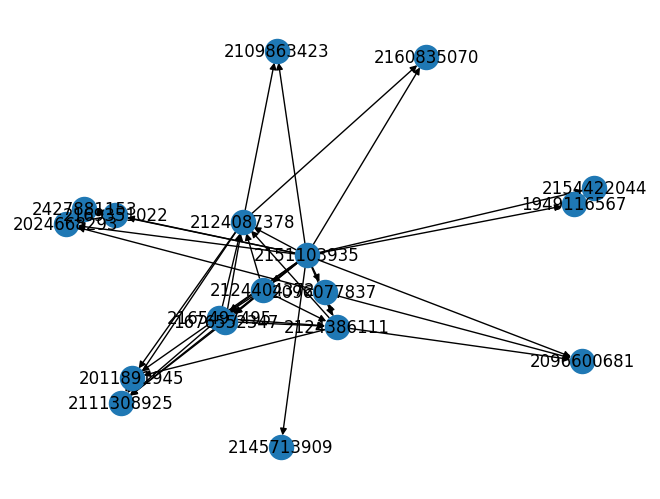

In [ ]:
# the first node, that will be showed, is extracted
first_node_to_show = dataset_top_citation_citation_graph.iloc[0]

# get the source node and the target node
source_node = first_node_to_show['id']
target_node = first_node_to_show['references_under_id']
subgraph_node_citation_graph = [source_node] + target_node

# a subgraph is extracted from the main graph containing the soruce node and target nodes specified
subgraph = G_citation.subgraph(subgraph_node_citation_graph)
pos = nx.spring_layout(subgraph)

# draw the subgraph
nx.draw(subgraph, pos, with_labels=True, arrowsize=10)
plt.show()

The nodes and the edges has been created according to what we said previously, **we decided to show a small subportion of the whole graph** by plotting only the first node (the node that corresponds to the first id) with the relative edges and nodes to which it is connected. As we can see from the plot, the graph is not built to just show the relationships between the nodes under the column id and the relative nodes under the column `reference_under_id`, but it represents the relationships among the nodes present inside that column, as for example, the relationship between the node 2124087378 and 2109863423.

## Collaboration graph

This graph representsthe second task of the Point 1, the target is to create a `collaboration graph` that should represent the collaborations of the papers' authors, it should be weighted and undirected.
The necessary column for this task was the column `authors`, and we isoltaed it to perform all the operations, creating the dataset `dataset_top_citation_collaboration_graph`. Similarly to the column `references`, the rows under this column were just singular strings, so we had to manipulate them closely to what we did for the citation graph. Once we processed them we just got lists of strings in the form ['id' 'numeric id']. Our goal was to obtain a column similar to the `refernces` one, to reach this target, we used the function clean_strings_authors, that extracts just the numeric values form the strings inside the lists, in order to have only the numeric ids on which we will build the final graph.

In [ ]:
dataset_top_citation_collaboration_graph = dataset_top_citation[['authors']]
dataset_top_citation_collaboration_graph

,authors
0,"[{'name': 'David G. Lowe', 'org': 'Computer Sc..."
1,"[{'name': 'Leo Breiman', 'org': 'Statistics De..."
2,"[{'name': 'Chih-Chung Chang', 'org': 'National..."
3,"[{'name': 'Fred D. Davis', 'org': 'Computer an..."
4,"[{'name': 'Corinna Cortes', 'org': 'AT&T Bell ..."
...,...
9995,"[{'name': 'Pawan Goyal', 'org': 'Distributed M..."
9996,"[{'name': 'Jessica K. Hodgins', 'org': 'Colleg..."
9997,"[{'name': 'Richard J. Lipton', 'id': 277112432..."
9998,"[{'name': 'Claudio S. Pinhanez', 'org': 'IBM T..."


In [ ]:
# the squared brackes are deleted from the authors column
dataset_top_citation_collaboration_graph.loc[:,'authors'] = dataset_top_citation_collaboration_graph['authors'].apply(lambda x: x.replace('[', '').replace(']', '')).copy()

# the curly brackes are deleted from the authors column
dataset_top_citation_collaboration_graph.loc[:,'authors'] = dataset_top_citation_collaboration_graph['authors'].apply(lambda x: x.replace('{', '').replace('}', '')).copy()

# the 2 points are deleted from the authors column
dataset_top_citation_collaboration_graph.loc[:,'authors'] = dataset_top_citation_collaboration_graph['authors'].apply(lambda x: x.replace(':', '')).copy()

# the name 'David' is deleted from the authors column, because of the presence of the word id in it
dataset_top_citation_collaboration_graph.loc[:,'authors'] = dataset_top_citation_collaboration_graph['authors'].apply(lambda x: x.replace('David', '')).copy()

# for each row of the column authors a list of strings is created
dataset_top_citation_collaboration_graph.loc[:,'authors'] = dataset_top_citation_collaboration_graph['authors'].apply(lambda x: x.split(','))

# only the strings with the word 'id' are kept
dataset_top_citation_collaboration_graph.loc[:,'authors'] = dataset_top_citation_collaboration_graph['authors'].apply(lambda authors: list(filter(lambda author: 'id' in author, authors)))
dataset_top_citation_collaboration_graph

,authors
0,[ 'id' 2104328312]
1,[ 'id' 2569376642]
2,"[ 'id' 2895256545, 'id' 2168176072]"
3,[ 'id' 2427477170]
4,"[ 'id' 2134830209, 'id' 2022407533]"
...,...
9995,"[ 'id' 2152918269, 'id' 2020627909, 'id' 266..."
9996,"[ 'id' 601642093, 'id' 1980379243, 'id' 2030..."
9997,"[ 'id' 2771124329, 'id' 350567680]"
9998,[ 'id' 320969846]


In [ ]:
# the function clean_strings_authors is created to keep only the numeric values,
#so it removes the non-digit characters
def clean_strings_authors(lst):
    cleaned_list = []
    for x in lst:
        ids_authors_only = ''.join(char for char in x if char.isdigit())
        if ids_authors_only:
            cleaned_list.append(int(ids_authors_only))

    # the output is a list of cleaned integers
    return cleaned_list

# the column authors is updated by applying the previous function
dataset_top_citation_collaboration_graph.loc[:,'authors'] = dataset_top_citation_collaboration_graph['authors'].apply(clean_strings_authors)
dataset_top_citation_collaboration_graph

,authors
0,[2104328312]
1,[2569376642]
2,"[2895256545, 2168176072]"
3,[2427477170]
4,"[2134830209, 2022407533]"
...,...
9995,"[2152918269, 2020627909, 2662983009]"
9996,"[601642093, 1980379243, 2030310643, 2104748382]"
9997,"[2771124329, 350567680]"
9998,[320969846]


In [ ]:
# an undericted graph called 'G_collaboration' is created
G_collaboration = nx.Graph()

for _, row in dataset_top_citation_collaboration_graph.iterrows():
    author_list = row['authors']

    # interation through all the combinations of 2 authors with itertools
    for collaboration in itertools.combinations(author_list, 2):

        # checks if the collaboration edge already exists in the collaboration graph
        if G_collaboration.has_edge(*collaboration):

            # if the edge exists the weight is incremented by 1
            G_collaboration[collaboration[0]][collaboration[1]]['weight'] += 1
        else:
            # id the edge does not exist, the weight is set to 1
            G_collaboration.add_edge(*collaboration, weight=1)

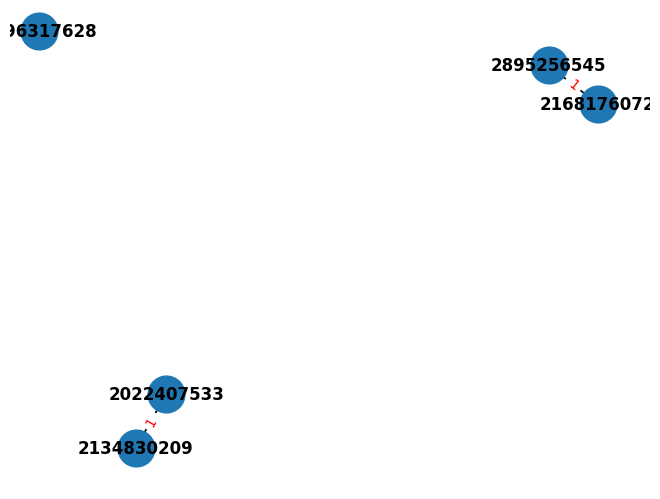

In [ ]:
# the first 5 nodes from the collaboration graph are taken
nodes_to_show = list(G_collaboration.nodes())[:5]

# a subgraph made of the selected nodes is created
subgraph_collaboration = G_collaboration.subgraph(nodes_to_show)
pos = nx.spring_layout(subgraph_collaboration)

# draw the subgraph
nx.draw(subgraph_collaboration, pos, with_labels=True, font_weight='bold', node_size=700)
edge_weights = {(i, j): subgraph_collaboration[i][j]['weight'] for i, j in subgraph_collaboration.edges()}
nx.draw_networkx_edges(subgraph_collaboration, pos,
                       width=[subgraph_collaboration[i][j]['weight'] for i, j in subgraph_collaboration.edges()])
nx.draw_networkx_edge_labels(subgraph_collaboration, pos, edge_labels=edge_weights, font_color='red')
plt.show()

As long as this second graph contains the weights, we would like explicit what we used as weights: the final collaboration graph contains a red number inside the edge, that number is the weight of that edge and it represents how many times that authors collaborated, for example in the final plot the authors 2895256545 and 2168176072 collaborated just one time, this means that these 2 ids appear just one time in the same list under the column author in the whole dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/HM5/citations_dataset_final.csv')
dataset

In [ ]:
dataset

,id,num_authors,authors,n_citation,reference_count,references
0,1091,8.0,"[{'name': 'Makoto Satoh', 'org': 'Shinshu Univ...",1,2.0,"[2005687710, 2018037215]"
1,1388,1.0,"[{'name': 'Pranava K. Jha', 'id': 2718958994}]",1,NaN,NaN
2,1674,2.0,"[{'name': 'G. Beale', 'org': 'Archaeological C...",1,15.0,"[1535888970, 1992876689, 1993710814, 203565334..."
3,1688,4.0,"[{'name': 'Altaf Hossain', 'org': 'Department ...",6,3.0,"[1560724230, 1986968751, 2156909104]"
4,5411,4.0,"[{'name': 'Rafael Álvarez', 'id': 2125293936},...",0,NaN,NaN
...,...,...,...,...,...,...
4894076,99905544,5.0,"[{'name': 'S. Nandagopalan', 'org': 'Dept. of ...",2,8.0,"[1562217771, 1625504505, 2015022770, 210875170..."
4894077,99884553,1.0,"[{'name': 'Koen Cornelis Hubertus Blom', 'org'...",0,NaN,NaN
4894078,999847014,11.0,"[{'name': 'Gert Læssøe Mikkelsen', 'org': 'Ale...",1,6.0,"[1940933138, 1975620021, 1978183200, 209759592..."
4894079,9990887,2.0,"[{'name': 'Rajesh Natarajan', 'org': 'Indian I...",0,NaN,NaN


# **[Q2] Controlling system**

The objective is to establish a control system where the user will be presented with a menu containing various functionalities. The user should have the ability to choose from five different functionalities, which will be implemented in the upcoming two sections. This system is designed to enable users to query and access functionalities of interest

# suggestion: remove and make alltogether backend and frontend as I already "did" some frontend application (and remove 2.1 backend implemented text cell: ONLY TITLE)

## **2.1 Backend implementation**

 In this section we implement the different functionalities as classes and we can find the implementation in the corrispondent python files

### **Functionality 1 - Graph's features**

This function should examine a graph and report on some of its features.
In particular we're interested in the: **The number of the nodes**, **number of edges**, **density**, **degree distribution**, **average degree**, **graph hubs** and finally a boolean values if the graph is **dense** or sparse.

The particolar threshold of density we consider `0.6` as moltiplicative factor as, typically, NOT dense graph has really lower number of edges r.t.w. the maximum number of edges. We also like this assessment as we consider it logical

we can address the functionalities rispectivly calling the following methods      
> nnodes

> nedges

> density

> degreedistr

> averagedegree

> hubs

> isdense


In [ ]:
from feature1 import GetFeature1
g = GetFeature1(G, 'fake')

In [ ]:
# As asked only 10000 nodes were selected among all nodes
g.nnodes

10000

In [ ]:
# Calculating the number of edges
g.nedges

55150

In [ ]:
round(g.density,5)

0.00055

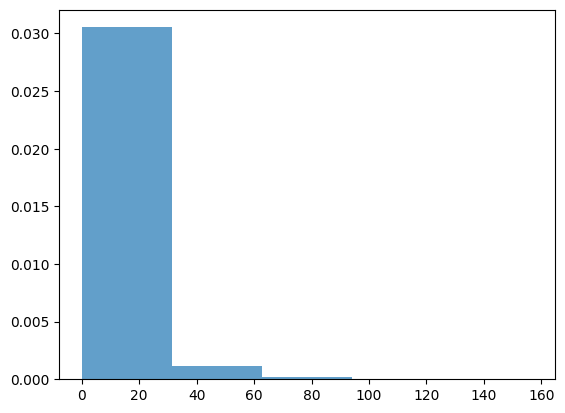

In [ ]:
# We have a very raugh representation of the degree distribution
# We find the number of nodes on the x label and the density on the y "axis"
g.degreedistr

Recalling that  a hub in graph theory refers to a node with a high degree, connected to a large number of other nodes in the network. They are often identified based on their high degree centrality, which quantifies the number of connections a node has.

Some nodes from the list of hubs are printed.

In [ ]:
# We select some random nodes which are hubs
g.hubs[450:455] # are 456 in total

['2128749719', '1772076007', '2167050549', '2141167937', '2108767394']

In [ ]:
g.isdense

False

We found the density through networkx, but levaraging the following formula for the density of a graph G with $n$ nodes and $m$:

$$D=\dfrac{2m}{n⋅(n−1)}$$

For our graph with 10.000 nodes and 55.150 edges we have:

$$D=\dfrac{2\cdot55.150}{10.000⋅(10.000−1)}\approx 0.0011$$​

whose density is really far off for any reasonable threshold that a graph is dense

### **Functionality 2 - Nodes' contribution**

Using this functionality, we can identify the papers/authors who have significantly contributed to this field of study. In order to achieve a more complete analysis we will examine the graph using various centrality measurements such as **betweeness**, **pageRank**, **closeness**, **centrality**.

We can call it as methods of aour class through the following instructions:
### **nodecentrality**

The betweenness centrality B(x) of a node $x$ is calculated based on the number of shortest paths that pass through $x$, normalized by the total number of shortest paths in the network:

$$B(x)=∑_{s\neq x \neq t}\dfrac{σ_{st}(x)}{σ_{st}}$$

Where:

  $σ_{st}​$ is the total number of shortest paths from node $s$ to node $t$.

  $σ_{st}​(x)$ is the number of those paths that pass through node $x$.


### **pagerank**

Pagerank is a link analysis algorithm used by search engines to assign a numerical weight to each element of a hyperlinked set of documents, such as the World Wide Web, with the purpose of measuring its relative importance within the set

### **closeness**

The closeness centrality is a measure of a node's centrality within a graph, which gauges how close a node is to all other nodes. For an undirected graph, the closeness centrality (C(v)) of a node v is defined as the reciprocal of the sum of the shortest distances from v to all other nodes in the graph:

$$\displaystyle C(v)=\dfrac{1}{\sum_{u}d(v,u)}$$

Here, $d(v,u)$ represents the shortest distance between nodes v and u. For a directed graph, closeness centrality is generally defined similarly, but considering only reachable or incoming nodes.

### **degreecentrality**
The degree centrality D(x) of a node $x$ is the number of edges incident to that node, normalized by the total number of nodes in the network minus one:

$$D(x)=\dfrac{\text{Number of edges incident to x}}{N-1}​$$

where $N$ is the total number of nodes in the network.

In [ ]:
from feature2 import GetFeature2

#### Example 1

In [ ]:
h = GetFeature2(subgraph, '2151103935', 'citation subgraph')
h.closeness

0.0

In [ ]:
round(h.pagerank,5)

0.03139

In [ ]:
h.nodecentrality

0.0

In [ ]:
h.degreecentrality

1.0

#### Example 2

In [ ]:
h1 = GetFeature2(subgraph, '1676552347', 'citation subgraph')
round(h1.closeness,5)


0.11765

In [ ]:
round(h1.pagerank,5)

0.03997

In [ ]:
round(h1.nodecentrality,5)

0.00123

In [ ]:
round(h1.degreecentrality,5)

0.35294

### **Functionality 3 - Shortest ordered walk**

In this functionality we're asked to find the shortest orderd walks. We have in input: the graph data, a sequence of authors_a and initial and a final node and a number N. As output we want  to get from author a_1 to author a_n and the papers you need to cross to realize this walk.

It returns a message when the graph is not fully connected neither exists a shortest path between two specified nodes.

We decided to return the shortest path also when a list is not given.

In the specific case of the **Collaboration graph**, as it is not so dense, we decide non to use this parameter for the sake of visualization as it would be of no interest.

**N is a parameter to filter the first authors with respect to the number of papers they have written**. Furthermore the choice of weights in the collaboration graphs was free and we decided to pick the number of collaborations.

So in order to choose the top N authors we decide to extract the exact number of papers for each author from the real dataset, and not approximated from the graph. Indeed summing the outgoing edges would at least exclude two hihgly probably cases:

1. articles publishes solitarly
2. the case in which an article was written by 3+ hands there would be 2 connections but the article would still be one


You can find the selection of the top authors in the followings cell of code


#### find the authors with the higher number of articles published

In [ ]:
# We consider the original dataset to have the orginal number of total papers published
top_authors= dataset[['id','authors']]
top_authors

,id,authors
2937610,2151103935,"[{'name': 'David G. Lowe', 'org': 'Computer Sc..."
4088311,2911964244,"[{'name': 'Leo Breiman', 'org': 'Statistics De..."
2691785,2153635508,"[{'name': 'Chih-Chung Chang', 'org': 'National..."
688041,1791587663,"[{'name': 'Fred D. Davis', 'org': 'Computer an..."
2313078,2119821739,"[{'name': 'Corinna Cortes', 'org': 'AT&T Bell ..."
...,...,...
1443467,2032881500,"[{'name': 'Tong Zhu', 'org': 'Dept. of Comput...."
1443452,2032879541,"[{'name': 'John Ayoade', 'org': 'American Univ..."
1443458,2032880699,"[{'name': 'Adrian Rusu', 'org': 'Dept. of Comp..."
1443466,2032881482,"[{'name': 'Óscar J. Rubio', 'org': 'Aragon In..."


In [ ]:
# We see how our data is structured and how authors-ids are stored
top_authors['authors'][0]

"[{'name': 'Makoto Satoh', 'org': 'Shinshu University', 'id': 2312688602}, {'name': 'Ryo Muramatsu', 'org': 'Shinshu University', 'id': 2482909946}, {'name': 'Mizue Kayama', 'org': 'Shinshu University', 'id': 2128134587}, {'name': 'Kazunori Itoh', 'org': 'Shinshu University', 'id': 2101782692}, {'name': 'Masami Hashimoto', 'org': 'Shinshu University', 'id': 2114054191}, {'name': 'Makoto Otani', 'org': 'Shinshu University', 'id': 1989208940}, {'name': 'Michio Shimizu', 'org': 'Nagano Prefectural College', 'id': 2134989941}, {'name': 'Masahiko Sugimoto', 'org': 'Takushoku University, Hokkaido Junior College', 'id': 2307479915}]"

In [ ]:
# We construct our counter as a dictionary
authors_publishedict = defaultdict(int)

# Iterating over each row
for idx, row in top_authors.iterrows():
    authors = row['authors']

    # Iterate over author dictionaries in the 'authors' columns list
    for auth_dict in ast.literal_eval(authors):
        author_id = auth_dict.get('id')

        # Count the occurrences of each author's id in authors_publishedict and
        # update the counter of our own dicitonary
        authors_publishedict[author_id] += 1



In [ ]:
# Add  a new column to the dataset so we can filter about top-N authors
authors_publisheddf= pd.DataFrame(list(authors_publishedict.items()), columns=['id', 'PublicationCount'])

In [ ]:
# We save it so to call it in the function extract if we
#wanted to exctract top-authors. As a matter of fact we we will
#call connected_authors we won't apply the filtering selection though
path_csv = '/content/authors_publisheddf.csv'
authors_publisheddf.to_csv(path_csv, index=False)

In [ ]:
# Sorting according to the number of articles published
new_df = authors_publisheddf.sort_values(by='PublicationCount', ascending=False)
new_df

,id,PublicationCount
4650,1976698169,1290
13109,703410400,1153
1919,2125104194,1135
5920,2029230138,1084
10259,688402840,1061
...,...,...
1667906,2529296952,1
1667905,2168883319,1
1667904,2974858411,1
1667901,2438493545,1


#### To implement the third feature we need some more functions which, for readibility, we stored in a python file. We check all details there: you will find

> **extract (graph, N)**: the function that filters for the top N authors

> **dijkstra (graph, start, stop)** : a function which finds the shortest path for a weighted graph between the first and the end node

> **connectauthor (graph, start, end, list)**: a function that returns the shortest connected graph which considers visiting all the node in the list in that order.

In [ ]:
# Importing our function
import feature3file as f3

How is the subgraph? Is it enough dense to get some reasonable path? We visualize it leveraging the cited function `extract`

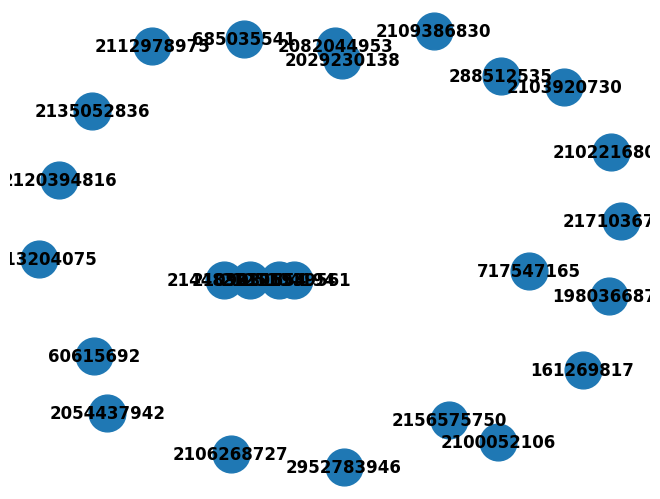

In [ ]:
# Selecting a subgraph with the top 120 authors
subres =f3.extract(G_collaboration, 120)

# See code in exercise1 for visuaization
nodes_to_show_sub = list(subres.nodes())[:25]
subgraph_collaboration = subres.subgraph(nodes_to_show_sub)
pos = nx.spring_layout(subgraph_collaboration)
nx.draw(subgraph_collaboration, pos, with_labels=True, font_weight='bold', node_size=700)
edge_weights = {(i, j): subgraph_collaboration[i][j]['weight'] for i, j in subgraph_collaboration.edges()}
nx.draw_networkx_edges(subgraph_collaboration, pos, width=[subgraph_collaboration[i][j]['weight'] for i, j in subgraph_collaboration.edges()])
nx.draw_networkx_edge_labels(subgraph_collaboration, pos, edge_labels=edge_weights, font_color='red')

plt.show()

In [ ]:
# Getting number of nodes
subres.number_of_nodes()

82

In [ ]:
# Get number of edges
subres.number_of_edges()

10

In [ ]:
# Filtered by top N author... really poor as initial and final node are the same
f3.connectauthor(subres, 2029230138, 2082044953, 150)

[2029230138, 2082044953]

#### As subgraph had only few edges (only 10!) we decide to plot with some different strategy w.r.t the one asked. We will proceed analogously for the fourth feature.

In [ ]:
# An example without filtering operation
f3.connectauthor(G_collaboration, 2104401652, 2027658599, 150, [2007415138] )

[2104401652,
 351197510,
 2435751034,
 2128170596,
 1978529654,
 1973035492,
 2159063947,
 2007415138,
 2027658599]

**Functionality 4 - Disconnecting Graphs**

The functionality is designed to calculate the minimum number of edges (taking into account their weights) required to disconnect the original graph into two disconnected subgraphs, denoted as G_a and G_b.

---

**By definition getting a minim number of edges is just a number and does not depend on the weights.**


Indeed if we have two possibility of having the same number of edges with different combination of edges such that they have differents cost, we will still get the same number of minimum number of edges.

---

We implement a variant of Karger algorithm to accomplish feature 4's aim.


#### custumed karger randomized algorithm

Yes, the **Karger**'s algorithm is a randomized algorithm, which means that its result can vary across different executions of the same input. Randomization is introduced in the choice of edges to contract during the graph contraction process. This randomness is used to achieve a higher probability of contracting edges that lead to the correct solution.

Karger's algorithm works through a series of random contractions of graph edges until only two nodes remain, representing the remaining connected components. The randomness in the algorithm increases the probability of obtaining an approximate solution, but not necessarily the optimal one, in reasonable time.

In [ ]:
import feature4 as f4

we interprete the sentence (considering weights) as follows


**AS IT IS A PROBABILISTIC ALGORITHIM WE THEN PERFORM THE OPERATION 10 TIMES BY DEFAULT AND TAKE THE NUMBER OF EDGES THAT MINIMIZES THE TOTAL COST**

Moreover we implement the functionality such that it returns not only the minimum numbers of the edges but all the path as couples of edges as it is the correct format if we want to remove it from the original graph.
We implent this in `weigthedmincut`.

---

**Also without this last step this would already be a solution that considers the weights**: if we define a function that equals one if two nodes are different and zero if we consider the same node; and choose this as `binary` distance.

As the request has several possible interpretretations and **as it is a probabilistic algorithm, it might be useful to repeat the experiment several times and see the solution with the minimum weight**.

#### this is the road we will follow




#### To implement the fourth feature we stor the following functions in a python file. You have all details there, where you will find:

> **find_components_dfs (graph)**: the function that finds all connected components in a graph

> **contract_edge (graph, node1, node2)** : a function which returns the new graph whith the contracted nodes and edges adjusted appropriatly

> **custom_karger (graph, start, end, list)**: a function that returns the shortest minicut choosing randomly the edges to select

> **considerweight(graph, start, end, it=10)**: Iterates to get the minicut $it$
times

> **weigthedmincut(list of the resulst)**: select the result with the minimum weight minicut

We list which nodes will be removed

In [ ]:
f4.custom_karger(G_collaboration, 2104401652, 2027658599)

[(2104401652, 2027658599),
 (2104401652, 2084034853),
 (2104401652, 2559180283),
 (2104401652, 1932590790),
 (2104401652, 2874782720),
 (2104401652, 2105531243),
 (1969547113, 2027658599),
 (1969547113, 2084034853),
 (1969547113, 2559180283),
 (1969547113, 1932590790),
 (1969547113, 2874782720),
 (1969547113, 2105531243)]

In [ ]:
f4.custom_karger(G_collaboration, 2104401652, 2027658599)

KeyboardInterrupt: 

In [ ]:
#We find the minimum number of edges through calculating the length
minremove= len(f4.custom_karger(G_collaboration, 2104401652, 2027658599))
minremove

12

In [ ]:
# We prove an easy example of the subgraph, were only one edge should be cut
# As it is indeed the only one that connect the two selected nodes.
# You can double check by looking at plot of the citation subgraph in Q1
f4.custom_karger(subgraph, 2145713909, 2151103935)

[(2145713909, 2151103935)]

In [34]:
import random
import networkx as nx

def find_components_dfs(graph):
    visited = set()
    components = []

    def dfs(node, component):
        '''
        The inner function dfs performs a recursive depth-first search starting from a given node. It adds the current node to the visited set and the current connected component. Then, for each neighbor of the current node, if the neighbor has not been visited, it recursively calls the dfs function on that neighbor.
        '''
        # Adding the node to the visited
        visited.add(node)
        # Adding the node to the set of component new_component called
        component.add(node)

        for neighbor in graph[node]:
            # Recursively calling dfs on the neighbours
            if neighbor not in visited:
                dfs(neighbor, component)

    #for each unvisited node in the graph
    for node in graph:
        if node not in visited:
            # we create a component - each node can be pontentially a component.
            #We're initialiating the component
            new_component = set()
            # Adding the neighbour node to the visited nodes
            dfs(node, new_component)
            # and to the components initial list
            components.append(new_component)

    # The function returns a list of connected components.
    return components


def contract_edge(graphr, u, v):
    '''
    Performs a contraction : given two nodes and a graph it return a new graph
    were the two nodes were joint and the edges appropriatly contracted
    '''
    # We create an edge we call in a name such that I can recognise the nodes from which the edge was conctracted
    contracted_node = f"{u}_{v}"

    # Add the new node to the graph
    graphr.add_node(contracted_node)

    # Dictionaries of nodes and his neighbours
    nn = graphr.adj[v].items()
    # Add the edges to new node which before were connected to u
    for neighbor, edge_data in nn:
        if neighbor != v:
            # using ** to copy all attributes of the edges (weights or examples)
            graphr.add_edge(contracted_node, neighbor, **edge_data)

    # Add the edges to new node which before were connected to v
    for neighbor, edge_data in nn:
        if neighbor != u:
            graphr.add_edge(contracted_node, neighbor, **edge_data)

    # Remove u and v from the graph
    graphr.remove_node(u)
    graphr.remove_node(v)


def custom_karger(graph, node1, node2):
    '''
    This function is a variation of the karger algorithm. Given two nodes it returns the edges we
    need to cut so that minimizes the number of edges to be cut. It this edges are removed we should get
    two connected component such that the first and second node beolngs to the first and second component
    rispectivly. Does NOT return a optimal solution as selects the edges randomly. This approch performs
    on average quite good and efficienty but sometimes may fail or return a non-optimal solution.
    '''
    # We create a copy of the original graph
    graph_original=graph.copy()
    # And one more to perform the contraction
    gr = graph.copy()
    # We keep contracting while
    while len(gr.nodes()) > 2 and len(gr.edges()) > 0:
        # Select casually edges to contract
        edge = random.choice(list(gr.edges()))
        # Identify the nodes incident on the edge
        u, v = edge

        #print('new iteration', gr.nodes())
        # Contract the selected edge
        contract_edge(gr, u, v)

    # Returns the connected components
    components = list(find_components_dfs(gr))

    #creare a list for all connected components
    first_elements = [[] for _ in range(len(components))]
    # a counter to go through the list
    i=0
    # To store the mincut
    res= []

    # Apply conversion
    for elem in components:
        # first from set component I convert it to a ist
        elements_list = list(elem)

        # I extract all element from the, now, list
        # Get all the original nodes from the list of contracted node, if a list
        for element in elements_list:
            if type(element)!=int:
                node = element.split('_')
                node = [int(elem) for elem in node]
                try:
                    first_elements[i]+=node
                except IndexError:
                     return ("Retry")
            # If a component is a number because made up of a node only
            else:
                # append the elemnt to the list
                first_elements[i].append(element)
            i +=1


    print('fe', first_elements)
    # Select only the component with the two node of interest
    f_elements = [elem for elem in first_elements if node1 in elem or node2 in elem]

    # Initialize local variabile to store the minicut
    #nmin = 0
    # Andd the total weight of the mincut
    #totw=0
    if len(f_elements)==2:
        for u in f_elements[0]:
            for v in f_elements[1]:
                # Check if edge which connect the contracted nodes exists
                if graph_original.has_edge(str(u),str(v)) or graph_original.has_edge(str(v),str(u)):
                #    nmin += 1
                    # get informations about the edges
                    #edge_data = graph.get_edge_data(u, v)
                    #print('edge', edge_data)
                    # Extract the weight if we want to take it into account
                    #peso_arco = edge_data['weight']
                    # adding the weight to store the total cost of that cut
                    #totw += peso_arco
                    # And add it to the result
                    print(u,v)
                    res.append((u,v))
        # Eventually return the length of the shortest path directly
        #res.append(nmin)
        # Evenetually modify res so to store the total weight of the cut
        #res.append(totw)
        return(res)

    # When something went wrong in the contraction
    else:
        return "Are already two disconnected components"



def considerweight(GG,n1,n2, it=10):
    res1=[[]]
    j=0
    while j<it:
        # Iterates to get multiple cuts for sake of consistency
        a= custom_karger(GG,n1, n2)
        res1[0].append(a)
        j+=1
    return(res1)

def weigthedmincut(listres1):
    # Retrieves only the lists
    edges_with_weights = [item[0] for item in listres1 if isinstance(item, list) and len(item) == 2 and item!="Retry"]

    if not edges_with_weights:
        return "Are already two disconnected components"

    # Get the edges with minimum weight
    min_weight_edge = min(edges_with_weights, key=lambda x: x[1])

    return(min_weight_edge)



In [36]:
custom_karger(G_collaboration, 2104401652, 2027658599)

NetworkXError: The node 22 is not in the graph.

# Command Line

In this question we use command line tools to answer the following questions on Citation graph:

[Q1.] Is there any node that acts as an important "connector" between the

> **APPROCH**

[Q2.] different parts of the graph?

> **APPROCH**

[Q3.] How does the degree of citation vary among the graph nodes?
What is the average length of the shortest path among nodes?

> **APPROCH**: use the library nx to get the shortest path, took the average and print the result with `echo`